## Using Protoypical Networks for trust modeling with CLAS database

Dataset: CLAS (Cognitive Load, Affect and Stress Database)

Credits to dataset owners:

  Markova, V., Ganchev, T., Kalinkov, K. (2019). CLAS: A Database for Cognitive Load, Affect and Stress Recognition, in Proceedings of the International Conference on Biomedical Innovations and Applications, (BIA-2019), art. no. 8967457,  DOI: 10.1109/BIA48344.2019.8967457. Available on-line: https://ieeexplore.ieee.org/document/8967457

Steps

1. Download the dataset at https://ieee-dataport.org/open-access/database-cognitive-load-affect-and-stress-recognition
2. Run the training and test script.



In [13]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from scipy.signal import butter, lfilter

# Define data directory based on CLAS dataset structure
DATA_DIR = "CLAS/Participants/"  # Update with the actual path to the dataset
# Define the directory for Answers
ANSWERS_DIR = "CLAS/Answers/"

def load_answers(participant):
    """
    Load the answer file for a given participant and convert to numerical labels.
    """
    # print(participant)
    answer_file = os.path.join(ANSWERS_DIR, f"{participant}_c_i_answers.csv")
    if not os.path.exists(answer_file):
        return None  # Skip if file doesn't exist
    
    df = pd.read_csv(answer_file)
    # print(df.head())

    # print("Columns in the answer file:", df.columns)

    # Map textual answers to numeric labels safely
    df = df.copy()  # Ensure modifications apply to a copy
    df['label'] = df[' answer'].map({'correct': 1, 'incorrect': 0, 'empty': 0}).fillna(0)


    return df['label'].values  # Return as a numpy array

def segment_signals(ecg, gsr, ppg, num_segments=74):
    """
    Segments physiological signals into `num_segments` parts to align with Y labels.
    Returns an array of features per segment.
    """
    segment_size = len(ecg) // num_segments  # Calculate window size per segment
    
    segmented_features = []
    for i in range(num_segments):
        start = i * segment_size
        end = (i + 1) * segment_size if i < num_segments - 1 else len(ecg)

        segment_ecg = ecg[start:end]
        segment_gsr = gsr[start:end]
        segment_ppg = ppg[start:end]

        # Extract statistical features for each segment
        features = [
            np.mean(segment_ecg), np.std(segment_ecg),
            np.mean(segment_gsr), np.std(segment_gsr), np.ptp(segment_gsr),
            np.mean(segment_ppg), np.std(segment_ppg)
        ]
        
        segmented_features.append(features)

    return np.array(segmented_features)
    
def load_clas_data():
    all_features = []
    all_labels = []
    
    for participant in os.listdir(DATA_DIR):
        participant_dir = os.path.join(DATA_DIR, participant)
        if "Part" in participant_dir and os.path.isdir(participant_dir):
            # print(participant_dir)
            ecg_file = os.path.join(participant_dir, "full_ecg.csv")
            gsr_file = os.path.join(participant_dir, "full_gsr_ppg.csv")
            
            if not os.path.exists(ecg_file) or not os.path.exists(gsr_file):
                continue  # Skip if required files are missing
            
            # Load and clean physiological signals
            ecg_data = load_filtered_csv(ecg_file)
            gsr_data = load_filtered_csv(gsr_file)
            
            # Extract ECG, GSR, and PPG
            ecg = ecg_data.iloc[:, 1].values
            gsr = gsr_data.iloc[:, 1].values
            ppg = gsr_data.iloc[:, 2].values
            
            # Load corresponding answer labels
            labels = load_answers(participant)
            if labels is None or len(labels) == 0:
                continue  # Skip participants with no answer labels
            
            # Ensure exactly 74 labels exist (trim/pad if necessary)
            labels = labels[:74] if len(labels) >= 74 else np.pad(labels, (0, 74 - len(labels)), 'constant')

            # Segment physiological signals into 74 parts
            features = segment_signals(ecg, gsr, ppg, num_segments=74)

            # Ensure features and labels have the same length
            assert len(features) == len(labels), f"Feature-label mismatch for {participant}: {len(features)} features, {len(labels)} labels"

            # Store the features with the updated labels
            all_features.extend(features)  # Flatten participant data
            all_labels.extend(labels)  # Ensure labels are correctly assigned
    
    return np.array(all_features), np.array(all_labels)
    
# Function to load and filter CSV data
def load_filtered_csv(file_path):
    """
    Load CSV file and remove rows containing metadata or non-numeric values.
    """
    df = pd.read_csv(file_path)  # Skip first row if it contains invalid headers
    
    # Drop rows where 'Timestamp' contains text (like 'Start Next Stimulus')
    df = df[df.iloc[:, 0].apply(lambda x: str(x).replace('.', '').isdigit())]
    
    # Convert all columns except Timestamp to numeric, forcing errors to NaN
    df.iloc[:, 1:] = df.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')

    # Drop any remaining NaN rows
    df.dropna(inplace=True)
    
    return df

# # Function to load CLAS data dynamically
# Load data
features, labels = load_clas_data()

print(f"Feature shape: {features.shape}, Label shape: {labels.shape}")
print(f"Updated Label distribution: {dict(zip(*np.unique(labels, return_counts=True)))}")

# Ensure balanced class distribution
unique, counts = np.unique(labels, return_counts=True)
print(f"Label distribution: {dict(zip(unique, counts))}")

# Split Data
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, stratify=labels, random_state=42
)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# PyTorch Dataset
class TrustDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

train_dataset = TrustDataset(X_train, y_train)
test_dataset = TrustDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=False)


# Prototypical Network Model
class ProtoNet(nn.Module):
    def __init__(self, input_dim, embedding_dim=128):
        super(ProtoNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, embedding_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Training & Evaluation
def compute_prototypes(embeddings, labels, num_classes):
    """
    Compute prototypes for each class with normalization to prevent instability.
    """
    prototypes = []
    for c in range(num_classes):
        class_embeddings = embeddings[labels == c]
        if len(class_embeddings) == 0:
            continue  # Skip empty class (rare but possible)

        prototype = class_embeddings.mean(dim=0)

        # Normalize prototypes to prevent instability
        prototype = prototype / (torch.norm(prototype, p=2) + 1e-6)

        prototypes.append(prototype)

    return torch.stack(prototypes) if prototypes else torch.zeros((num_classes, embeddings.shape[1]))


def prototypical_loss(prototypes, embeddings, labels):
    """
    Compute Prototypical Loss with numerical stability fixes.
    """
    # Compute Euclidean distance with epsilon for stability
    dists = torch.cdist(embeddings, prototypes, p=2) + 1e-6  # Small epsilon to prevent zero distances

    # Normalize distances
    dists = dists / (torch.norm(dists, dim=1, keepdim=True) + 1e-6)

    # Log-Sum-Exp Trick for stability
    log_prob = -F.log_softmax(-dists, dim=1)

    # Ensure labels are correct dtype
    labels = labels.long()

    # Compute weighted loss to handle class imbalance
    loss = F.cross_entropy(-dists, labels, reduction='mean')

    return loss


def train_protonet(model, train_loader, num_classes, optimizer, scheduler, epochs=50):
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0.0
        for features, labels in train_loader:
            optimizer.zero_grad()

            embeddings = model(features)
            prototypes = compute_prototypes(embeddings, labels, num_classes)
            loss = prototypical_loss(prototypes, embeddings, labels)

            if torch.isnan(loss):  # Prevent NaN propagation
                print(f"NaN detected at epoch {epoch+1}, skipping batch.")
                continue

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            epoch_loss += loss.item()

        scheduler.step()  # Decay learning rate

        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.4f}')


def evaluate_protonet(model, test_loader, num_classes):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for features, labels in test_loader:
            embeddings = model(features)
            prototypes = compute_prototypes(embeddings, labels, num_classes)
            dists = torch.cdist(embeddings, prototypes)
            _, predicted = torch.min(dists, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')



Feature shape: (4366, 7), Label shape: (4366,)
Updated Label distribution: {0.0: 1600, 1.0: 2766}
Label distribution: {0.0: 1600, 1.0: 2766}


In [14]:
# Train protype

input_dim = X_train.shape[1]
num_classes = len(np.unique(y_train))
model = ProtoNet(input_dim=input_dim, embedding_dim=128)
optimizer = optim.SGD(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)


# Check for NaN or inf values in features
print("Checking for NaN or Inf in features...")
print("NaN values:", np.isnan(features).sum())
print("Inf values:", np.isinf(features).sum())

# Replace NaN or Inf values with zero (safe handling)
features = np.nan_to_num(features, nan=0.0, posinf=0.0, neginf=0.0)

# Ensure numerical stability
assert not np.isnan(features).any(), "Error: Features still contain NaN!"
assert not np.isinf(features).any(), "Error: Features still contain Inf!"

train_protonet(model, train_loader, num_classes, optimizer, scheduler, epochs=50)


Checking for NaN or Inf in features...
NaN values: 0
Inf values: 0
Epoch 1/50, Loss: 0.6787
Epoch 2/50, Loss: 0.6801
Epoch 3/50, Loss: 0.6801
Epoch 4/50, Loss: 0.6797
Epoch 5/50, Loss: 0.6789
Epoch 6/50, Loss: 0.6755
Epoch 7/50, Loss: 0.6795
Epoch 8/50, Loss: 0.6755
Epoch 9/50, Loss: 0.6773
Epoch 10/50, Loss: 0.6772
Epoch 11/50, Loss: 0.6773
Epoch 12/50, Loss: 0.6767
Epoch 13/50, Loss: 0.6800
Epoch 14/50, Loss: 0.6774
Epoch 15/50, Loss: 0.6765
Epoch 16/50, Loss: 0.6791
Epoch 17/50, Loss: 0.6787
Epoch 18/50, Loss: 0.6767
Epoch 19/50, Loss: 0.6752
Epoch 20/50, Loss: 0.6736
Epoch 21/50, Loss: 0.6767
Epoch 22/50, Loss: 0.6758
Epoch 23/50, Loss: 0.6760
Epoch 24/50, Loss: 0.6774
Epoch 25/50, Loss: 0.6758
Epoch 26/50, Loss: 0.6736
Epoch 27/50, Loss: 0.6754
Epoch 28/50, Loss: 0.6748
Epoch 29/50, Loss: 0.6722
Epoch 30/50, Loss: 0.6746
Epoch 31/50, Loss: 0.6748
Epoch 32/50, Loss: 0.6741
Epoch 33/50, Loss: 0.6758
Epoch 34/50, Loss: 0.6744
Epoch 35/50, Loss: 0.6737
Epoch 36/50, Loss: 0.6736
Epoch 

In [15]:
# Test protype
evaluate_protonet(model, test_loader, num_classes)

Test Accuracy: 64.87%


Epoch 1/50, Loss: 1.6981
Epoch 2/50, Loss: 0.6718
Epoch 3/50, Loss: 0.6581
Epoch 4/50, Loss: 0.6495
Epoch 5/50, Loss: 0.6510
Epoch 6/50, Loss: 0.6464
Epoch 7/50, Loss: 0.6469
Epoch 8/50, Loss: 0.6443
Epoch 9/50, Loss: 0.6462
Epoch 10/50, Loss: 0.6446
Epoch 11/50, Loss: 0.6398
Epoch 12/50, Loss: 0.6403
Epoch 13/50, Loss: 0.6399
Epoch 14/50, Loss: 0.6400
Epoch 15/50, Loss: 0.6416
Epoch 16/50, Loss: 0.6399
Epoch 17/50, Loss: 0.6363
Epoch 18/50, Loss: 0.6393
Epoch 19/50, Loss: 0.6390
Epoch 20/50, Loss: 0.6391
Epoch 21/50, Loss: 0.6362
Epoch 22/50, Loss: 0.6355
Epoch 23/50, Loss: 0.6357
Epoch 24/50, Loss: 0.6376
Epoch 25/50, Loss: 0.6361
Epoch 26/50, Loss: 0.6349
Epoch 27/50, Loss: 0.6345
Epoch 28/50, Loss: 0.6322
Epoch 29/50, Loss: 0.6317
Epoch 30/50, Loss: 0.6326
Epoch 31/50, Loss: 0.6320
Epoch 32/50, Loss: 0.6337
Epoch 33/50, Loss: 0.6323
Epoch 34/50, Loss: 0.6307
Epoch 35/50, Loss: 0.6322
Epoch 36/50, Loss: 0.6296
Epoch 37/50, Loss: 0.6307
Epoch 38/50, Loss: 0.6293
Epoch 39/50, Loss: 0.

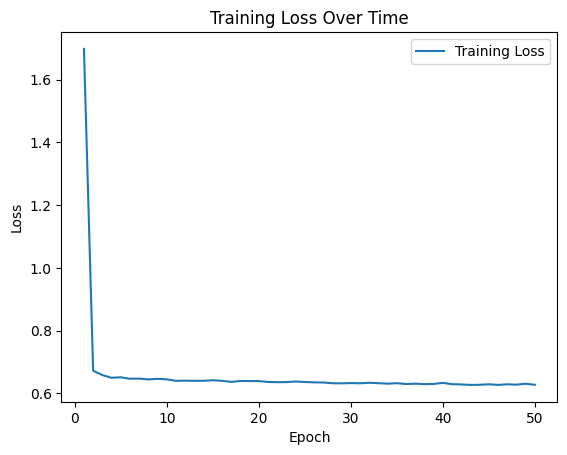

Test Accuracy: 65.33%


65.33180778032036

In [19]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from scipy.signal import butter, lfilter

# Define data directory based on CLAS dataset structure
DATA_DIR = "CLAS/Participants/"  # Update with the actual path to the dataset
# Define the directory for Answers
ANSWERS_DIR = "CLAS/Answers/"

def load_answers(participant):
    answer_file = os.path.join(ANSWERS_DIR, f"{participant}_c_i_answers.csv")
    if not os.path.exists(answer_file):
        return None  
    df = pd.read_csv(answer_file)
    df = df.copy()
    df['label'] = df[' answer'].map({'correct': 1, 'incorrect': 0, 'empty': 0}).fillna(0)
    return df['label'].values  

def segment_signals(ecg, gsr, ppg, num_segments=74):
    segment_size = len(ecg) // num_segments
    segmented_features = []
    for i in range(num_segments):
        start = i * segment_size
        end = (i + 1) * segment_size if i < num_segments - 1 else len(ecg)
        segment_ecg = ecg[start:end]
        segment_gsr = gsr[start:end]
        segment_ppg = ppg[start:end]
        features = [
            np.mean(segment_ecg), np.std(segment_ecg),
            np.mean(segment_gsr), np.std(segment_gsr), np.ptp(segment_gsr),
            np.mean(segment_ppg), np.std(segment_ppg)
        ]
        segmented_features.append(features)
    return np.array(segmented_features)

def load_filtered_csv(file_path):
    df = pd.read_csv(file_path)
    df = df[df.iloc[:, 0].apply(lambda x: str(x).replace('.', '').isdigit())]
    df.iloc[:, 1:] = df.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')
    df.dropna(inplace=True)
    return df

def load_clas_data():
    all_features = []
    all_labels = []
    for participant in os.listdir(DATA_DIR):
        participant_dir = os.path.join(DATA_DIR, participant)
        if "Part" in participant_dir and os.path.isdir(participant_dir):
            ecg_file = os.path.join(participant_dir, "full_ecg.csv")
            gsr_file = os.path.join(participant_dir, "full_gsr_ppg.csv")
            if not os.path.exists(ecg_file) or not os.path.exists(gsr_file):
                continue  
            ecg_data = load_filtered_csv(ecg_file)
            gsr_data = load_filtered_csv(gsr_file)
            ecg = ecg_data.iloc[:, 1].values
            gsr = gsr_data.iloc[:, 1].values
            ppg = gsr_data.iloc[:, 2].values
            labels = load_answers(participant)
            if labels is None or len(labels) == 0:
                continue  
            labels = labels[:74] if len(labels) >= 74 else np.pad(labels, (0, 74 - len(labels)), 'constant')
            features = segment_signals(ecg, gsr, ppg, num_segments=74)
            assert len(features) == len(labels)
            all_features.extend(features)
            all_labels.extend(labels)
    return np.array(all_features), np.array(all_labels)

features, labels = load_clas_data()
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, stratify=labels, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

class TrustDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

train_dataset = TrustDataset(X_train, y_train)
test_dataset = TrustDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=False)

class ProtoNet(nn.Module):
    def __init__(self, input_dim, embedding_dim=128):
        super(ProtoNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, embedding_dim)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def train_protonet(model, train_loader, num_classes, optimizer, scheduler, epochs=50):
    model.train()
    losses = []
    for epoch in range(epochs):
        epoch_loss = 0.0
        for features, labels in train_loader:
            optimizer.zero_grad()
            embeddings = model(features)
            loss = F.cross_entropy(embeddings, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            epoch_loss += loss.item()
        scheduler.step()
        losses.append(epoch_loss / len(train_loader))
        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.4f}')
    plt.plot(range(1, epochs+1), losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Time')
    plt.legend()
    plt.show()

def evaluate_protonet(model, test_loader, num_classes):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for features, labels in test_loader:
            embeddings = model(features)
            _, predicted = torch.max(embeddings, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    return accuracy

input_dim = X_train.shape[1]
num_classes = len(np.unique(y_train))
model = ProtoNet(input_dim=input_dim, embedding_dim=128)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)
train_protonet(model, train_loader, num_classes, optimizer, scheduler, epochs=50)
evaluate_protonet(model, test_loader, num_classes)
